# Flower Classification

**Exploracion de datos y Preprocesamiento**

**Yalila Aljure Jimenez**

email: yalila.aljure@udea.edu.co

CC. 5288540



**IMPORTING LIBRARIES**

In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
import keras
keras.__version__

'2.6.0'

In [3]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [24]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
import random
import math 
from sklearn.metrics import roc_curve, auc,multilabel_confusion_matrix, plot_confusion_matrix, roc_auc_score
from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, InputLayer, Input
from keras.models import Sequential, Model
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

**LOAD DATA**

In [5]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-11-01 18:21:54--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   192MB/s    in 1.1s    

2021-11-01 18:21:55 (192 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [6]:
# Unzipping Data
!gunzip flower_photos.tgz

In [ ]:
!tar -xvf flower_photos.tar

**Plotting Images**

In [8]:
data_dir = pathlib.Path('flower_photos')
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)

In [9]:
len(images) # Number of images

3670

In [10]:
fig = plt.figure(figsize=(20, 20))
iterable = np.array(random.sample(range(1, 3670), 54)) # Choosing 54 random images
for i in range(54):
    plt.subplot(9, 6, i+1)
    j = iterable[i]
    plt.title(str(images[j]).split('/')[-1], fontsize=10) # file name and disply as title
    plt.imshow(PIL.Image.open(images[j])) # Displaying Image
    ax = plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

**Parameters**

In [11]:
image_size = 224 # Setting the size of the images
b_size = 20

**Imagen Preprocessing**

Data Augmantation

Original source is not partitioned. The test set will be fixed at 20% of the entire dataset. The rest of the dataset will be used for training (0.8) and validation (0.2).

In [12]:
idg_flip = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split = 0.2
)

In [13]:
flower_gen_train = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    batch_size=b_size,
                                    subset='training',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 2939 images belonging to 5 classes.


In [14]:
flower_gen_test = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    batch_size=b_size,
                                    subset='validation',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 731 images belonging to 5 classes.


**VGGNet**

In [15]:
# Instanciate and empty model
model = Sequential()
# First Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='PReLU',padding='same',input_shape=(image_size,image_size,3))) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(64, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Second Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='PReLU', padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(128, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Third Convolutional Layer
model.add(Conv2D(256, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(256, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(256, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Fourth Convolutional Layer
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(BatchNormalization()) 
# Fith convolutional layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='PReLU',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(BatchNormalization()) 
# 1st dense layer
model.add(Flatten()) 
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5)) 
model.add(Activation('PReLU'))
# 2nd Dense Layer
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5))
# Normalization
model.add(BatchNormalization()) 
model.add(Activation('PReLU'))
# Output softmax layer
model.add(Dense(5))
model.add(Activation('softmax')) 

In [16]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      3213056   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      839744    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       475264    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0

In [18]:
Result = model.fit(flower_gen_train, validation_data=flower_gen_test
                   , epochs=100, verbose=1, shuffle=True)

Epoch 1/100
147/147 [==============================] - 103s 475ms/step - loss: 1.5896 - accuracy: 0.4012 - precision: 0.4783 - recall: 0.2882 - val_loss: 1.6062 - val_accuracy: 0.2175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
147/147 [==============================] - 67s 456ms/step - loss: 1.3866 - accuracy: 0.5036 - precision: 0.5617 - recall: 0.4151 - val_loss: 1.6137 - val_accuracy: 0.2175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
147/147 [==============================] - 67s 456ms/step - loss: 1.2829 - accuracy: 0.5322 - precision: 0.5894 - recall: 0.4396 - val_loss: 1.5036 - val_accuracy: 0.2969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
147/147 [==============================] - 67s 457ms/step - loss: 1.2116 - accuracy: 0.5539 - precision: 0.6211 - recall: 0.4634 - val_loss: 1.1385 - val_accuracy: 0.4843 - val_precision: 0.6609 - val_recall: 0.2613
Epoch 5/100
147/147 [==============================] - 67s 455m

In [19]:
mpl.rcParams.update({'font.size': 10, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

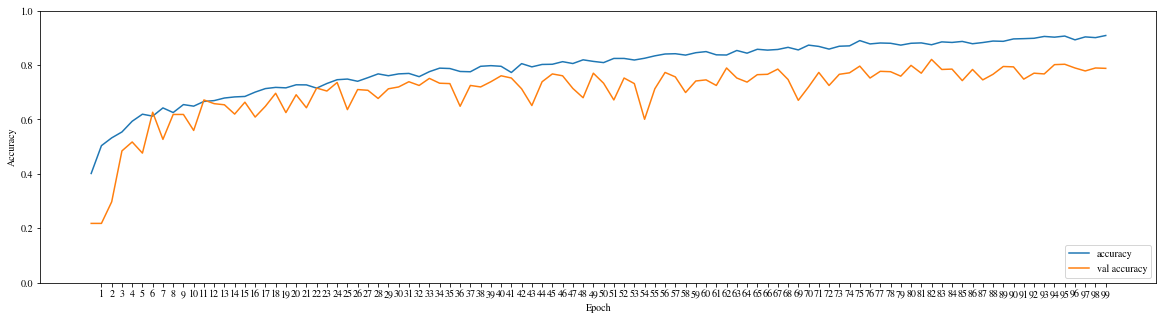

In [25]:
plt.figure(figsize=(20,5))
plt.plot(Result.history['accuracy'], label='accuracy')
plt.plot(Result.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,100)))
plt.ylim([0, 1])
plt.legend(loc='lower right')

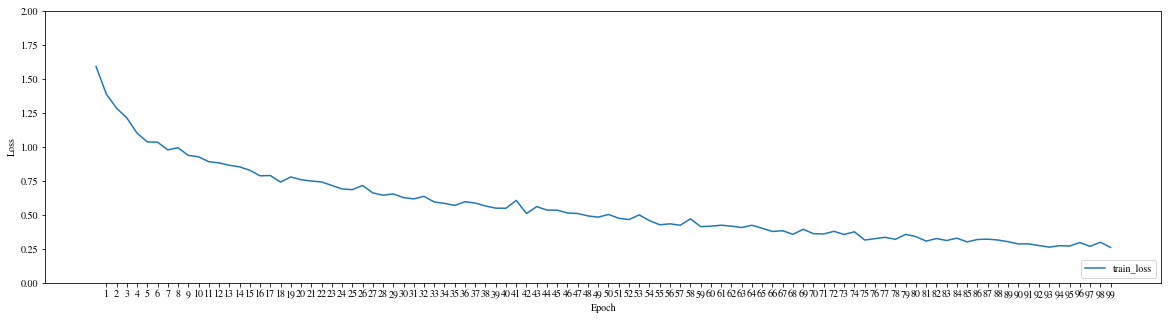

In [26]:
plt.figure(figsize=(20,5))
plt.plot(Result.history['loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(list(range(1,100)))
plt.ylim([0, 2])
plt.legend(loc='lower right')

In [22]:
flower_gen_test.reset()
x_test, y_test = next(flower_gen_test)
for i in tqdm(range(int(len(flower_gen_test.labels)/b_size))):
  img, label = next(flower_gen_test)
  x_test = np.append(x_test, img, axis = 0)
  y_test = np.append(y_test, label, axis = 0)

print(x_test.shape,y_test.shape)

100%|██████████| 36/36 [00:11<00:00,  3.21it/s]

(731, 224, 224, 3) (731, 5)


In [27]:
#plt.figure(figsize=(10,5))
y_pred = model.predict(x_test)
#y_pred = model.predict(x_test).ravel()
#fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred)
auc_keras = roc_auc_score(y_test,y_pred,multi_class='ovr')
print("ROC AUC score OVR:" + str(auc_keras))
#plt.title("ROC AUC score:" + str(auc_keras))
#plt.plot(y_test,y_pred, marker = ".")
auc_keras = roc_auc_score(y_test,y_pred,multi_class='ovo')
print("ROC AUC score OVO:" + str(auc_keras))

ROC AUC score OVR:0.9634717252071049
ROC AUC score OVO:0.9634717252071049


In [28]:
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [30]:
flower_labels = flower_gen_train.class_indices.keys()
print(flower_labels)

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])


Normalized confusion matrix
[[0.87301587 0.04761905 0.06349206 0.         0.01587302]
 [0.05027933 0.87150838 0.03910615 0.01675978 0.02234637]
 [0.03125    0.0078125  0.8515625  0.015625   0.09375   ]
 [0.04316547 0.08633094 0.12230216 0.73381295 0.01438849]
 [0.05031447 0.04402516 0.2327044  0.01257862 0.66037736]]


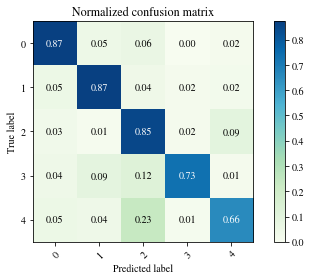

In [31]:
plot_confusion_matrix(y_test, y_pred, classes=np.r_[0,1,2,3,4], normalize=True, cmap=plt.cm.GnBu)

**Plot Evaluation**

In [32]:
model.save("07_model.h5")

In [33]:
def plot_example(X, y, y_pred=None):
# Create figure with 3 x 3 sub-plots.
  fig, axes = plt.subplots(3, 6)
  fig.set_size_inches(18,10)
  fig.subplots_adjust(hspace=0.3, wspace=0.3)
  X, y = X[:18, ..., 0], y[:18]
  for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(X[i])
    # Show true and predicted classes.
    if y_pred is None:
      xlabel = "True: {0}".format(y[i])
    else:
      xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])
    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)
    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
  plt.show()

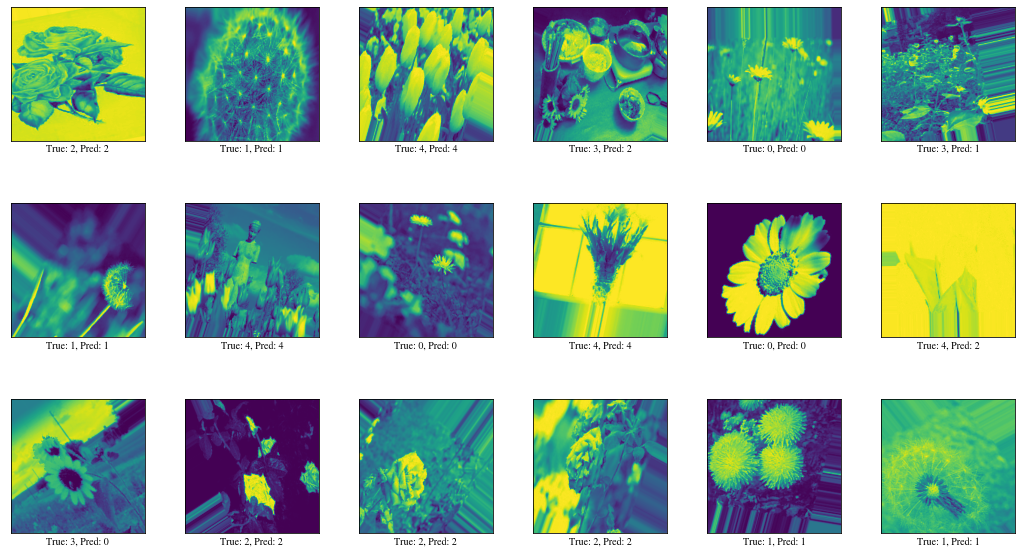

In [34]:
model = tf.keras.models.load_model('07_model.h5')
#%matplotlib inline
# Make prediction
predictions = model.predict(x_test)
# retrieve prediction indices
pred_y = np.argmax(predictions, axis=1)
# Plot some examples with model predictions
plot_example(x_test, y_test, pred_y)